In [2]:
import numpy as np 
import pandas as pd
import math
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
def import_data():
 data = pd.read_csv('norway_new_car_sales_by_make.csv')
 
 data['Period'] = data['Year'].astype(str) + '-' + data['Month'].astype(str).str.zfill(2)
 
 df = pd.pivot_table(data=data,values='Quantity',index='Make',columns='Period',aggfunc='sum',fill_value=0)
 return df

In [4]:
def datasets(df, x_len=12, y_len=1, test_loops=12):
 D = df.values
 rows, periods = D.shape
 # Training set creation
 loops = periods + 1- x_len- y_len
 train = []
 for col in range(loops):
    train.append(D[:,col:col+x_len+y_len])
 
 train = np.vstack(train)
 print(train.shape)
 X_train, Y_train = np.split(train,[-y_len],axis=1)
 # Test set creation
 if test_loops > 0:
    X_train, X_test = np.split(X_train,[-rows*test_loops],axis=0)

    Y_train, Y_test = np.split(Y_train,[-rows*test_loops],axis=0)
 else: # No test set: X_test is used to generate the future forecast
    X_test = D[:,-x_len:]
    Y_test = np.full((X_test.shape[0],y_len),np.nan) #Dummy value
 # Formatting required for scikit-learn
 if y_len == 1:
    Y_train = Y_train.ravel()
    Y_test = Y_test.ravel()
 return X_train, Y_train, X_test, Y_test

In [5]:
def kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name=''):
 df = pd.DataFrame(columns = ['MAE','RMSE','Bias'],index=['Train','Test'])
 df.index.name = name
 
 df.loc['Train','MAE'] = 100*np.mean(abs(Y_train-Y_train_pred))/np.mean(Y_train)

 df.loc['Train','RMSE'] = 100*np.sqrt(np.mean((Y_train-Y_train_pred)**2))/np.mean(Y_train)
 
 df.loc['Train','Bias'] = 100*np.mean((Y_train- Y_train_pred))/np.mean(Y_train)

 df.loc['Test','MAE'] = 100*np.mean(abs(Y_test- Y_test_pred))/np.mean(Y_test)
 
 df.loc['Test','RMSE'] = 100*np.sqrt(np.mean((Y_test-Y_test_pred)**2))/np.mean(Y_test)
 
 df.loc['Test','Bias'] = 100*np.mean((Y_test- Y_test_pred))/np.mean(Y_test)
 df = df.astype(float).round(1) #Round number for display
 print(df)

In [6]:
df = import_data()
X_train, Y_train, X_test, Y_test = datasets(df, x_len=12, y_len=1,test_loops=12)

(7085, 13)


In [7]:
#parameters
hidden_layer_sizes = [[neuron]*hidden_layer for neuron in range(10,60,10) for hidden_layer in range(2,7)]
alpha = [5,1,0.5,0.1,0.05,0.01,0.001]
learning_rate_init = [0.05,0.01,0.005,0.001,0.0005]
beta_1 = [0.85,0.875,0.9,0.95,0.975,0.99,0.995]

beta_2 = [0.99,0.995,0.999,0.9995,0.9999]
param_dist = {'hidden_layer_sizes':hidden_layer_sizes, 'alpha':alpha, 'learning_rate_init':learning_rate_init, 'beta_1':beta_1, 'beta_2':beta_2}

In [8]:
activation = 'relu'
solver = 'adam'
early_stopping = True
n_iter_no_change = 50
validation_fraction = 0.1
tol = 0.0001
param_fixed = {'activation':activation, 'solver':solver,
'early_stopping':early_stopping, 'n_iter_no_change':n_iter_no_change, 'validation_fraction':validation_fraction, 'tol':tol}

In [9]:
from sklearn.neural_network import MLPRegressor
NN = MLPRegressor(hidden_layer_sizes=(20,20), **param_fixed, verbose=True).fit(X_train, Y_train)

Iteration 1, loss = 3110.48324714
Validation score: 0.954314
Iteration 2, loss = 2917.97997112
Validation score: 0.956153
Iteration 3, loss = 2855.88884998
Validation score: 0.955238
Iteration 4, loss = 2840.48120712
Validation score: 0.954918
Iteration 5, loss = 2851.90352731
Validation score: 0.956658
Iteration 6, loss = 2801.73468298
Validation score: 0.955498
Iteration 7, loss = 2759.30477070
Validation score: 0.956967
Iteration 8, loss = 2713.25489424
Validation score: 0.956529
Iteration 9, loss = 2744.59670775
Validation score: 0.956364
Iteration 10, loss = 2712.76865519
Validation score: 0.956930
Iteration 11, loss = 2689.43275566
Validation score: 0.956365
Iteration 12, loss = 2756.18710959
Validation score: 0.951694
Iteration 13, loss = 2725.62287782
Validation score: 0.953764
Iteration 14, loss = 2699.56480187
Validation score: 0.954551
Iteration 15, loss = 2744.58597529
Validation score: 0.956111
Iteration 16, loss = 2700.99359374
Validation score: 0.956148
Iteration 17, los

In [10]:
from sklearn.model_selection import RandomizedSearchCV
NN = MLPRegressor(**param_fixed)
NN_cv = RandomizedSearchCV(NN, param_dist, cv=10, verbose=2, n_jobs=-1, n_iter=200, scoring='neg_mean_absolute_error')
NN_cv.fit(X_train,Y_train)
print('Tuned NN Parameters:', NN_cv.best_params_)
print()
Y_train_pred = NN_cv.predict(X_train)
Y_test_pred = NN_cv.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='NN optimized')

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Tuned NN Parameters: {'learning_rate_init': 0.01, 'hidden_layer_sizes': [30, 30, 30, 30, 30], 'beta_2': 0.99, 'beta_1': 0.99, 'alpha': 0.05}

               MAE  RMSE  Bias
NN optimized                  
Train         17.1  41.8   0.9
Test          17.4  44.0   2.2


<function matplotlib.pyplot.show(close=None, block=None)>

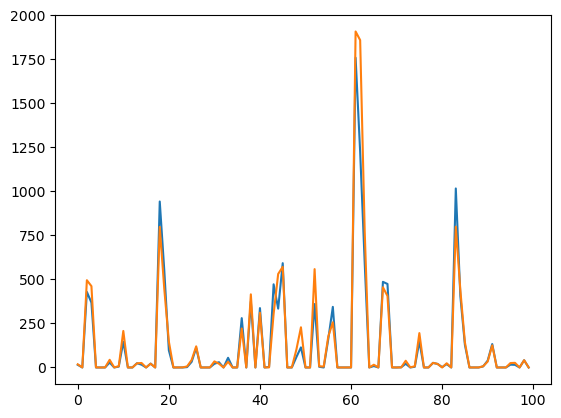

In [11]:
plt.plot(Y_train[:100])
plt.plot(Y_train_pred[:100])
plt.show